In [1]:
# 1. Imports and Setup
import numpy as np
import pandas as pd
import random, os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)


In [10]:
# 2. Load your dataset
data = pd.read_csv('df_final.csv')  # update path if needed
data.head()


,Unnamed: 0,Monthly Grocery Bill,Vehicle Monthly Distance Km,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,CarbonEmission,Body Type_normal,Body Type_obese,...,Cooking_With_['Oven'],"Cooking_With_['Stove', 'Grill', 'Airfryer']","Cooking_With_['Stove', 'Microwave', 'Grill', 'Airfryer']","Cooking_With_['Stove', 'Microwave']","Cooking_With_['Stove', 'Oven', 'Grill', 'Airfryer']","Cooking_With_['Stove', 'Oven', 'Microwave', 'Grill', 'Airfryer']","Cooking_With_['Stove', 'Oven', 'Microwave']","Cooking_With_['Stove', 'Oven']",Cooking_With_['Stove'],Cooking_With_[]
0,0,0.722892,0.021002,0.500000,0.291667,0.52,0.041667,0.239376,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0.257028,0.000900,0.333333,0.375000,0.76,0.208333,0.196506,0,1,...,0,0,0,1,0,0,0,0,0,0
2,2,0.353414,0.247225,0.000000,0.583333,0.94,0.250000,0.283608,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0.429719,0.007401,0.333333,0.833333,0.10,0.291667,0.095155,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0.867470,0.845785,0.000000,0.125000,0.10,0.250000,0.549746,0,1,...,1,0,0,0,0,0,0,0,0,0


In [11]:
X = data.drop('CarbonEmission', axis=1)
y = data['CarbonEmission']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)


In [12]:
def bootstrap_ci(y_true, y_pred, metric_fn, n_boot=1000, alpha=0.05):
    boot_scores = []
    n = len(y_true)
    idx = np.arange(n)
    for _ in range(n_boot):
        sample = np.random.choice(idx, size=n, replace=True)
        boot_scores.append(metric_fn(y_true[sample], y_pred[sample]))
    lo = np.percentile(boot_scores, 100 * alpha / 2)
    hi = np.percentile(boot_scores, 100 * (1 - alpha / 2))
    return np.mean(boot_scores), lo, hi


In [13]:
results = []

for depth in [5, 10, 20, None]:
    model = RandomForestRegressor(max_depth=depth, n_estimators=100, random_state=SEED)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae, lo, hi = bootstrap_ci(y_test.values, y_pred, mean_absolute_error)
    r2 = r2_score(y_test, y_pred)
    results.append({'max_depth': depth, 'MAE': mae, 'CI_low': lo, 'CI_high': hi, 'R2': r2})

df_results = pd.DataFrame(results)
df_results


,max_depth,MAE,CI_low,CI_high,R2
0,5.0,0.043803,0.042427,0.045030,0.797631
1,10.0,0.030124,0.029224,0.031042,0.903738
2,20.0,0.027470,0.026692,0.028286,0.916698
3,NaN,0.027594,0.026770,0.028445,0.916537


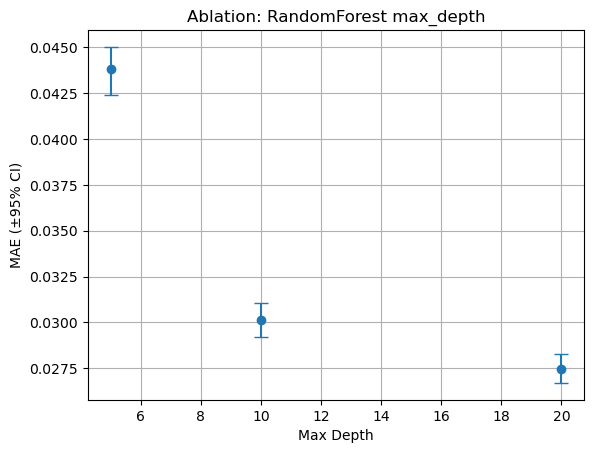

In [14]:
plt.errorbar(df_results['max_depth'], df_results['MAE'],
             yerr=[df_results['MAE']-df_results['CI_low'], df_results['CI_high']-df_results['MAE']],
             fmt='o', capsize=5)
plt.title('Ablation: RandomForest max_depth')
plt.xlabel('Max Depth')
plt.ylabel('MAE (±95% CI)')
plt.grid(True)
plt.show()


In [15]:
seeds = [0, 7, 21, 42, 99]
mae_scores = []

for s in seeds:
    rf = RandomForestRegressor(n_estimators=100, random_state=s)
    rf.fit(X_train, y_train)
    mae = mean_absolute_error(y_test, rf.predict(X_test))
    mae_scores.append(mae)

pd.DataFrame({'Seed': seeds, 'MAE': mae_scores})


,Seed,MAE
0,0,0.027551
1,7,0.027592
2,21,0.027449
3,42,0.027592
4,99,0.027532


In [18]:
summary = {
    'Mean MAE': np.mean(mae_scores),
    'Std MAE': np.std(mae_scores),
    'Best Depth': df_results.sort_values('MAE').iloc[0]['max_depth']  
}
pd.DataFrame([summary]).to_csv('ablation_summary.csv', index=False)
summary


{'Mean MAE': np.float64(0.02754320720274233),
 'Std MAE': np.float64(5.273635913218328e-05),
 'Best Depth': np.float64(20.0)}